In [ ]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


In [ ]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

#init

In [ ]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [ ]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

In [ ]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

In [ ]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [ ]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [ ]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(0)
    num_zeros=round(num_elements * sparsity)
    # Step 2: calculate the importance of weight
    importance = 0
    importance=torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    threshold = 0
    threshold=torch.kthvalue(importance.flatten(),num_zeros)
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = 0
    mask=torch.gt(importance,threshold.values)
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

In [ ]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

In [ ]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()


#1

In [ ]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

Downloading: "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth" to ./vgg.cifar.pretrained.pth
<ipython-input-25-231782152f6f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


In [ ]:
from torchvision import models

In [ ]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
dense model has size=35.20 MiB


In [ ]:
for name, param in model.named_parameters():
  print(name)

backbone.conv0.weight
backbone.bn0.weight
backbone.bn0.bias
backbone.conv1.weight
backbone.bn1.weight
backbone.bn1.bias
backbone.conv2.weight
backbone.bn2.weight
backbone.bn2.bias
backbone.conv3.weight
backbone.bn3.weight
backbone.bn3.bias
backbone.conv4.weight
backbone.bn4.weight
backbone.bn4.bias
backbone.conv5.weight
backbone.bn5.weight
backbone.bn5.bias
backbone.conv6.weight
backbone.bn6.weight
backbone.bn6.bias
backbone.conv7.weight
backbone.bn7.weight
backbone.bn7.bias
classifier.weight
classifier.bias


In [ ]:
c=0
for name, param in model.named_parameters():

    if param.dim() > 1:
        c+=1
        print(name)


In [ ]:
c

37

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10)


In [ ]:
for epoch in range(10):
   train(model, dataloader['train'], criterion, optimizer, scheduler, callbacks=None)

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

In [ ]:
new_dense_model_accuracy = evaluate(model, dataloader['test'])
print(new_dense_model_accuracy)

eval:   0%|          | 0/20 [00:00<?, ?it/s]

92.94999694824219


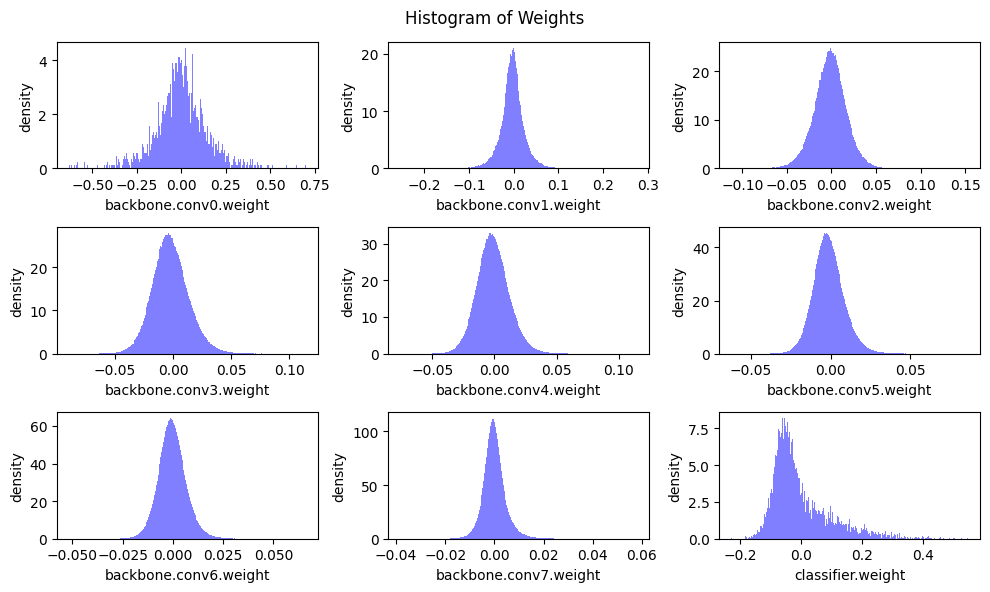

In [ ]:
plot_weight_distribution(model)

In [ ]:
model_size=get_model_size(model, count_nonzero_only=True)

In [ ]:
model_size

tensor(295307584, device='cuda:0')

In [ ]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

In [ ]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/9 weight - backbone.conv0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.42%, 91.19%, 87.55%, 83.39%, 69.41%, 31.81%]

scanning 1/9 weight - backbone.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=0.50: accuracy=92.88%

KeyboardInterrupt: 

In [ ]:
sparsity_dict_org={}
for name, param in model.named_parameters():
    if param.dim() > 1:
        sparsity_dict_org[name]=get_sparsity(param)

In [ ]:
sparsity_dict_org

{'backbone.conv0.weight': 0.0,
 'backbone.conv1.weight': 0.6000027126736112,
 'backbone.conv2.weight': 0.0,
 'backbone.conv3.weight': 0.0,
 'backbone.conv4.weight': 0.0,
 'backbone.conv5.weight': 0.0,
 'backbone.conv6.weight': 0.0,
 'backbone.conv7.weight': 0.0,
 'classifier.weight': 0.0}

In [ ]:
sparsity_dict_1={}
for name, param in model.named_parameters():
    if param.dim() > 1:
        sparsity_dict_1[name]=0.4

In [ ]:
sparsity_dict_1

{'backbone.conv0.weight': 0.4,
 'backbone.conv1.weight': 0.4,
 'backbone.conv2.weight': 0.4,
 'backbone.conv3.weight': 0.4,
 'backbone.conv4.weight': 0.4,
 'backbone.conv5.weight': 0.4,
 'backbone.conv6.weight': 0.4,
 'backbone.conv7.weight': 0.4,
 'classifier.weight': 0.4}

In [ ]:
sparsity_dict_2={}
sparsity_dict_3={}
for name, param in model.named_parameters():
    if param.dim() > 1:
        sparsity_dict_2[name]=0.5
        sparsity_dict_3[name]=0.6

In [ ]:
sparse_model_size = get_model_size(model, count_nonzero_only=True)

In [ ]:
sparse_model_size

tensor(293892000, device='cuda:0')

In [ ]:
sparse_model_size/get_model_size(model, count_nonzero_only=None)

tensor(0.9952, device='cuda:0')

In [ ]:
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")


Sparse model has size=35.03 MiB = 99.52% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=92.71% before fintuning


In [ ]:
model1=copy.deepcopy(model)
model2=copy.deepcopy(model)
model3=copy.deepcopy(model)



In [ ]:
model11=copy.deepcopy(model)
model12=copy.deepcopy(model)
model13=copy.deepcopy(model)


In [ ]:
pruner = FineGrainedPruner(model1, sparsity_dict_1)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict_1.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')


After pruning with sparsity dictionary
  backbone.conv0.weight: 0.40
  backbone.conv1.weight: 0.40
  backbone.conv2.weight: 0.40
  backbone.conv3.weight: 0.40
  backbone.conv4.weight: 0.40
  backbone.conv5.weight: 0.40
  backbone.conv6.weight: 0.40
  backbone.conv7.weight: 0.40
  classifier.weight: 0.40
The sparsity of each layer becomes


In [ ]:
pruner11 = FineGrainedPruner(model11, sparsity_dict_1)
pruner12 = FineGrainedPruner(model12, sparsity_dict_2)
pruner13 = FineGrainedPruner(model13, sparsity_dict_3)

In [ ]:
for name, param in model1.named_parameters():
    if name in sparsity_dict_1:
        print(f'  {name}: {get_sparsity(param):.2f}')

  backbone.conv0.weight: 0.40
  backbone.conv1.weight: 0.60
  backbone.conv2.weight: 0.40
  backbone.conv3.weight: 0.40
  backbone.conv4.weight: 0.40
  backbone.conv5.weight: 0.40
  backbone.conv6.weight: 0.40
  backbone.conv7.weight: 0.40
  classifier.weight: 0.40


In [ ]:
pruner2 = FineGrainedPruner(model2, sparsity_dict_2)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict_2.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')

After pruning with sparsity dictionary
  backbone.conv0.weight: 0.50
  backbone.conv1.weight: 0.50
  backbone.conv2.weight: 0.50
  backbone.conv3.weight: 0.50
  backbone.conv4.weight: 0.50
  backbone.conv5.weight: 0.50
  backbone.conv6.weight: 0.50
  backbone.conv7.weight: 0.50
  classifier.weight: 0.50
The sparsity of each layer becomes


In [ ]:
pruner3 = FineGrainedPruner(model3, sparsity_dict_3)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict_3.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')

After pruning with sparsity dictionary
  backbone.conv0.weight: 0.60
  backbone.conv1.weight: 0.60
  backbone.conv2.weight: 0.60
  backbone.conv3.weight: 0.60
  backbone.conv4.weight: 0.60
  backbone.conv5.weight: 0.60
  backbone.conv6.weight: 0.60
  backbone.conv7.weight: 0.60
  classifier.weight: 0.60
The sparsity of each layer becomes


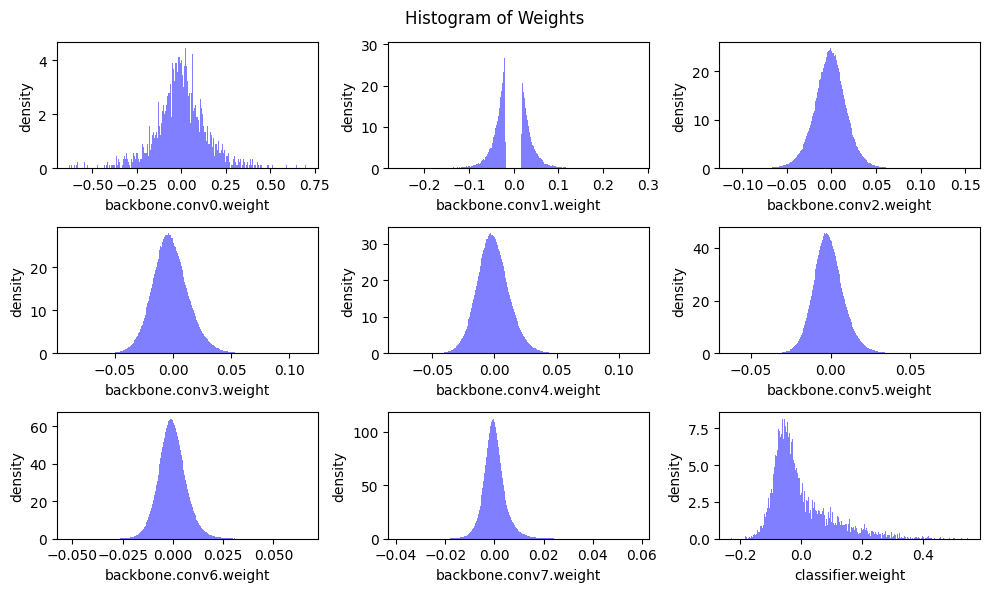

In [ ]:
plot_weight_distribution(model11, count_nonzero_only=True)

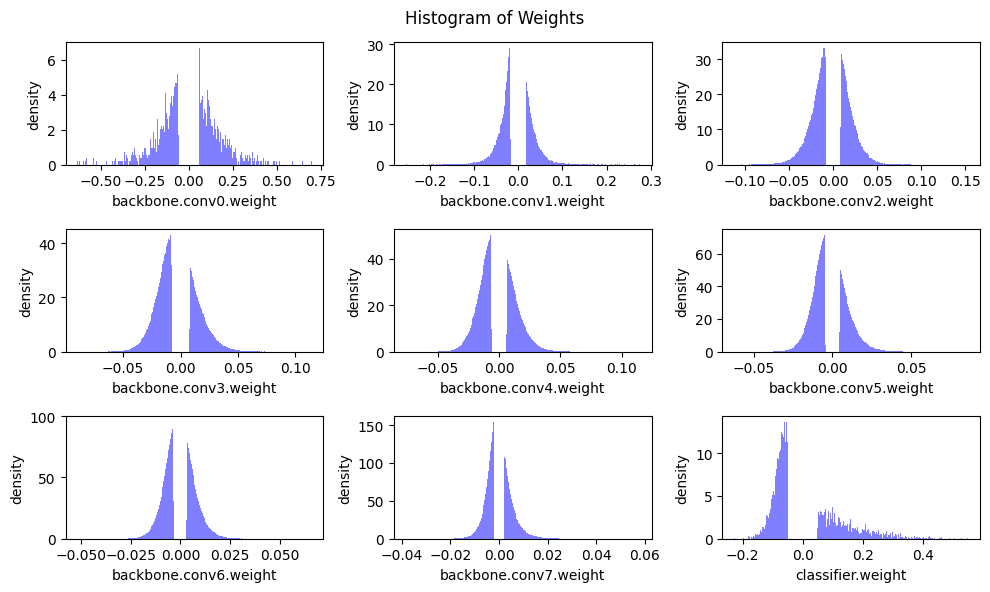

In [ ]:
plot_weight_distribution(model11, count_nonzero_only=True)

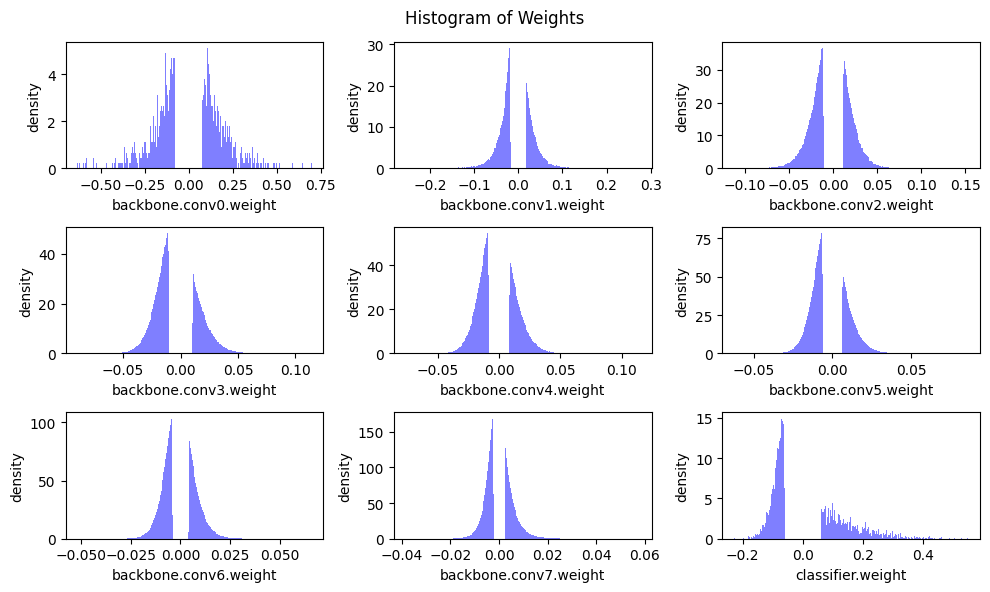

In [ ]:
plot_weight_distribution(model12, count_nonzero_only=True)

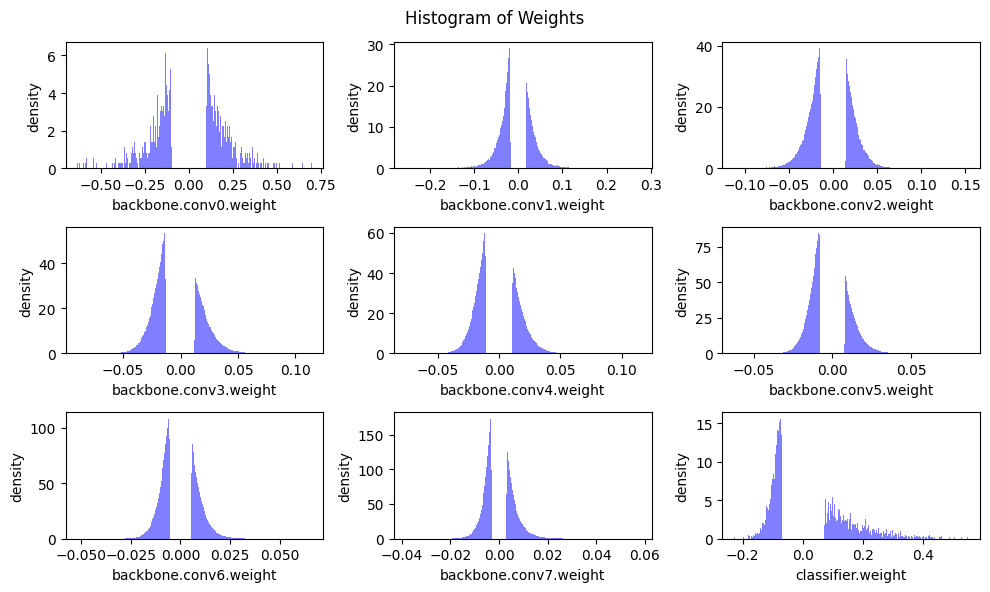

In [ ]:
plot_weight_distribution(model13, count_nonzero_only=True)

In [ ]:
pruner11 = FineGrainedPruner(model11, sparsity_dict_1)
pruner12 = FineGrainedPruner(model12, sparsity_dict_2)
pruner13 = FineGrainedPruner(model13, sparsity_dict_3)

In [ ]:
get_model_sparsity(model11)

0.4013587676772974

In [ ]:
get_model_sparsity(model12)

0.5005001971097363

In [ ]:
get_model_sparsity(model13)

0.5996416265421751

In [ ]:
get_model_sparsity(model)

0.0047935917555033125

In [ ]:
plot_weight_distribution(model11, count_nonzero_only=True)

In [ ]:
model21=copy.deepcopy(model)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
@torch.inference_mode()
def res(
    model: nn.Module,
    dataloader: DataLoader,
    verbose=True,
    plot_confusion_matrix=False
) -> float:
    model.eval()

    num_samples = 0
    num_correct = 0
    all_targets = []
    all_outputs = []

    for inputs, targets in tqdm(dataloader, desc="eval", leave=False, disable=not verbose):
        # Move data to GPU if available
        inputs = inputs.cuda()
        targets = targets.cuda()

        # Inference
        outputs = model(inputs)

        # Convert logits to class indices
        predicted = outputs.argmax(dim=1)
        all_targets.extend(targets.cpu().numpy())
        all_outputs.extend(predicted.cpu().numpy())

    return all_targets, all_outputs

In [ ]:
t,p=res(model, dataloader['test'])

eval:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix

In [ ]:
accuracy_score(t,p)

0.9271

In [ ]:
cm=confusion_matrix(t,p)

In [ ]:
def specificity(cm):
   specificities = []

    # Compute specificity for each class in a one-vs-rest fashion
   for i in range(10):
        # True negatives (TN) and false positives (FP) for class i
        tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        fp = np.sum(cm[:, i]) - cm[i, i]

        # Calculate specificity for class i
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        specificities.append(specificity)
   return specificities

In [ ]:
model_org_spe=specificity(cm)

In [ ]:
model_org_spe

[0.9918888888888889,
 0.9964444444444445,
 0.9897777777777778,
 0.9865555555555555,
 0.9883333333333333,
 0.9853333333333333,
 0.9923333333333333,
 0.997,
 0.9963333333333333,
 0.995]

In [ ]:
np.mean(model_org_spe)

0.9918999999999999

In [ ]:
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")
sparse_model_accuracy1 = evaluate(model1, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy1:.2f}% before fintuning")
sparse_model_accuracy2 = evaluate(model2, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy2:.2f}% before fintuning")
sparse_model_accuracy3 = evaluate(model3, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy3:.2f}% before fintuning")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=92.71% before fintuning


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=92.25% before fintuning


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=90.85% before fintuning


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=87.25% before fintuning


In [ ]:
from sklearn.metrics import recall_score

In [ ]:
recall_score(t,p,average='macro')

0.9270999999999999

In [ ]:
recall_score(t,p,average='micro')

0.9271

In [ ]:
recall_score(t1,p1,average='macro')

0.9225

In [ ]:
recall_score(t2,p2,average='macro')

0.9085000000000001

In [ ]:
recall_score(t3,p3,average='macro')

0.9085000000000001

In [ ]:
t1,p1=res(model1, dataloader['test'])

eval:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
t2,p2=res(model2, dataloader['test'])

eval:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
t3,p3=res(model2, dataloader['test'])

eval:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
accuracy_score(t1,p1)

0.9225

In [ ]:
accuracy_score(t2,p2)

0.9085

In [ ]:
accuracy_score(t3,p3)

0.9085

In [ ]:
cm1=confusion_matrix(t1,p1)
cm2=confusion_matrix(t2,p2)
cm3=confusion_matrix(t3,p3)

In [ ]:
model_1_spe=specificity(cm1)
model_2_spe=specificity(cm2)
model_3_spe=specificity(cm3)

In [ ]:
model_1_spe

[0.9933333333333333,
 0.9971111111111111,
 0.9881111111111112,
 0.9862222222222222,
 0.9852222222222222,
 0.9878888888888889,
 0.9921111111111112,
 0.9962222222222222,
 0.994,
 0.9936666666666667]

In [ ]:
model_2_spe

[0.9937777777777778,
 0.9973333333333333,
 0.9866666666666667,
 0.9826666666666667,
 0.9836666666666667,
 0.989,
 0.9891111111111112,
 0.9965555555555555,
 0.9894444444444445,
 0.9901111111111112]

In [ ]:
model_3_spe

[0.9937777777777778,
 0.9973333333333333,
 0.9866666666666667,
 0.9826666666666667,
 0.9836666666666667,
 0.989,
 0.9891111111111112,
 0.9965555555555555,
 0.9894444444444445,
 0.9901111111111112]

In [ ]:
np.mean(model_org_spe)

0.9918999999999999

In [ ]:
np.mean(model_1_spe)

0.9913888888888888

In [ ]:
np.mean(model_2_spe)

0.9898333333333333

In [ ]:
np.mean(model_3_spe)

0.9898333333333333

In [ ]:
from sklearn.metrics import precision_score

In [ ]:
precision_score(t,p,average='macro')

0.9272873928504725

In [ ]:
precision_score(t1,p1,average='macro')

0.9225878091946068

In [ ]:
precision_score(t2,p2,average='macro')

0.9091645400518725

In [ ]:
precision_score(t3,p3,average='macro')

0.9091645400518725

In [ ]:
criterion = nn.CrossEntropyLoss()
num_finetune_epochs = 5

In [ ]:
optimizer = optimizer = torch.optim.Adam(model1.parameters(), lr=0.01,  weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
best_sparse_model_checkpoint1 = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    train(model1, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model1)])
    accuracy = evaluate(model1, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint1['state_dict'] = copy.deepcopy(model1.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 1 Accuracy 71.03% / Best Accuracy: 71.03%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 2 Accuracy 69.53% / Best Accuracy: 71.03%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 3 Accuracy 71.17% / Best Accuracy: 71.17%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 4 Accuracy 72.70% / Best Accuracy: 72.70%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 5 Accuracy 72.27% / Best Accuracy: 72.70%


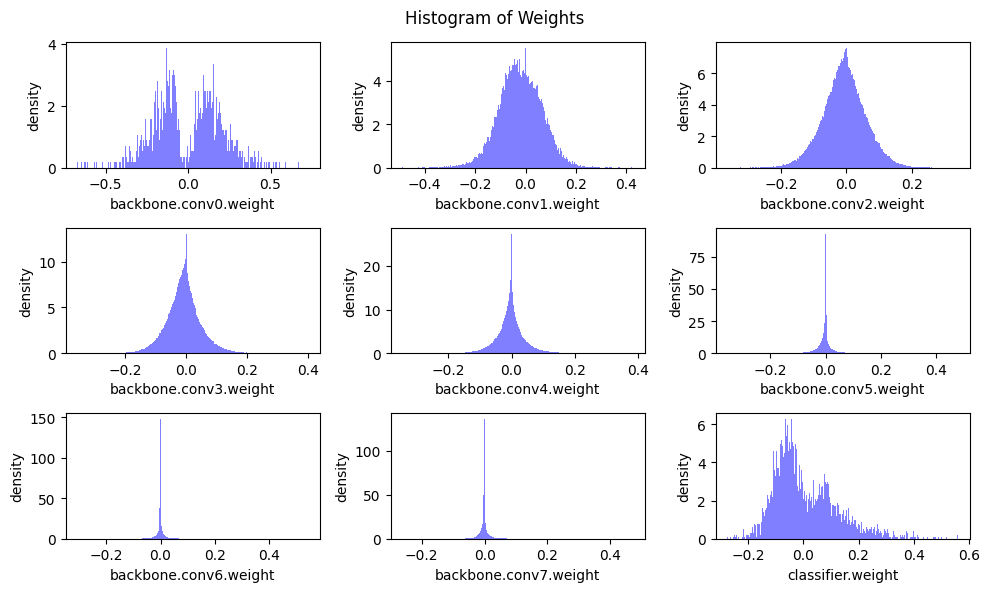

In [ ]:

plot_weight_distribution(model1, count_nonzero_only=True)

In [ ]:
optimizer = optimizer = torch.optim.Adam(model2.parameters(), lr=0.01,  weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
best_sparse_model_checkpoint2 = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model2, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner2.apply(model2)])
    accuracy = evaluate(model2, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint2['state_dict'] = copy.deepcopy(model2.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 1 Accuracy 69.05% / Best Accuracy: 69.05%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 2 Accuracy 78.58% / Best Accuracy: 78.58%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 3 Accuracy 70.01% / Best Accuracy: 78.58%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 4 Accuracy 70.78% / Best Accuracy: 78.58%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 5 Accuracy 68.54% / Best Accuracy: 78.58%


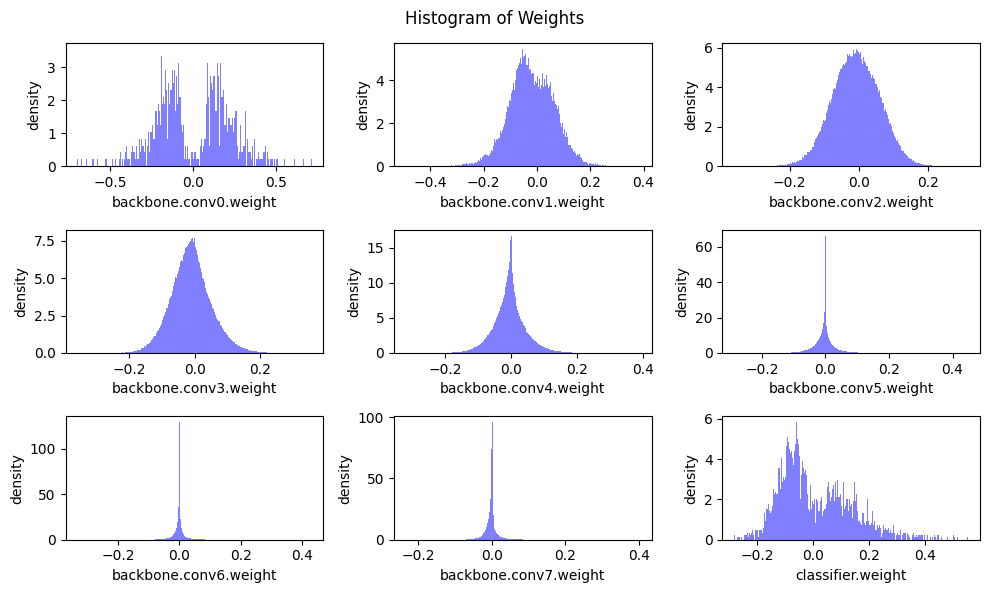

In [ ]:
plot_weight_distribution(model2, count_nonzero_only=True)

In [ ]:

optimizer = optimizer = torch.optim.Adam(model3.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
best_sparse_model_checkpoint3 = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model3, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner3.apply(model3)])
    accuracy = evaluate(model3, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint3['state_dict'] = copy.deepcopy(model3.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 1 Accuracy 74.89% / Best Accuracy: 74.89%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 2 Accuracy 75.24% / Best Accuracy: 75.24%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 3 Accuracy 74.25% / Best Accuracy: 75.24%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 4 Accuracy 58.86% / Best Accuracy: 75.24%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 5 Accuracy 81.34% / Best Accuracy: 81.34%


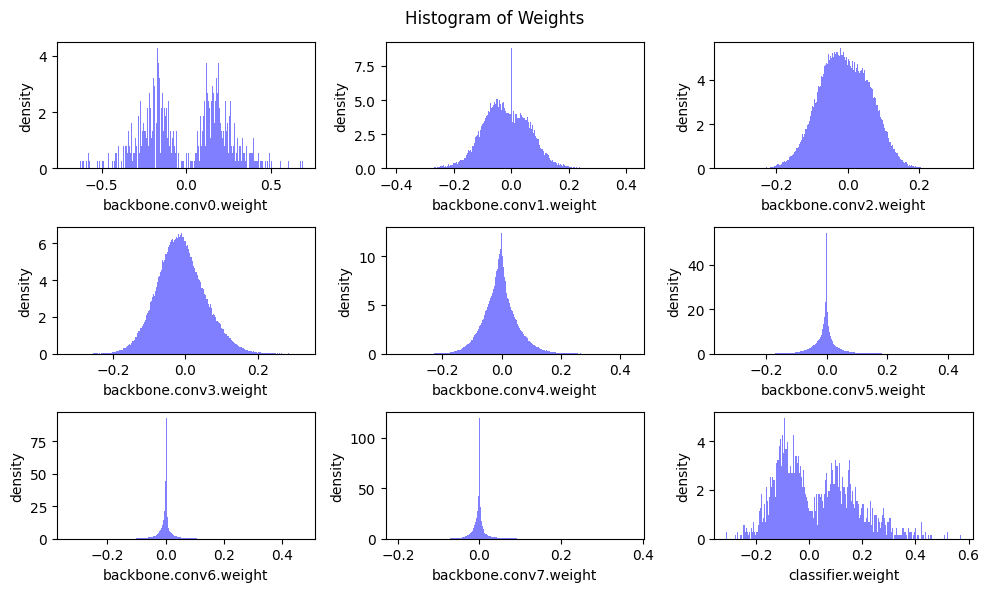

In [ ]:
plot_weight_distribution(model3, count_nonzero_only=True)

In [ ]:

optimizer = optimizer = torch.optim.Adam(model3.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model3, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner3.apply(model3)])
    accuracy = evaluate(model3, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

In [ ]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model11.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint11 = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model11, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner11.apply(model11)])
    accuracy = evaluate(model11, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint11['state_dict'] = copy.deepcopy(model11.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 1 Accuracy 92.89% / Best Accuracy: 92.89%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 2 Accuracy 92.90% / Best Accuracy: 92.90%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 3 Accuracy 92.81% / Best Accuracy: 92.90%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 4 Accuracy 92.86% / Best Accuracy: 92.90%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 5 Accuracy 92.92% / Best Accuracy: 92.92%
